### Notes on Logistic Regression

The data consists of:

- A collection D of N d-dimensional column vectors x (so an 
    (d,N) data matrix) 
    
- A label for each column vector between 0 and k-1 which we represent as an 
    (k,N)
    matrix $L$ such that the jth column has a 1 in the ith row if D[:,j] is in class i,
    and zeroes elsewhere in that column.

The logistic regression model has for parameters a matrix W of size (k,d)
and a bias vector b of
size (k,1). To simplify the notation, let's add a dimension to our column
vectors and set every last value to 1; then we can treat the biases
as part of our matrices W.  From now on our dimension d includes this extra
dimension.


Let $\sigma$ be the softmax function.  The model assigns the multinomial probabilities
$\sigma(Wx)$ to x and we wish to maximize the likelihood of the data given W.  Note that $\sigma(Wx)$  is a (k,1) column vector. 

The relevant loss function is the log-likelihood of the model.  Suppose
that the point $D[:,j]$ belongs to class $i$. Then 

$$
\sum_{j=1}^{N} log\sigma(W[i,:]D[:,j])
$$

In other words, the log-likelihood has a contribution equal to the log of the
probability that the model assigns to point j belonging to its actual class.
We want to maximize this.

To apply gradient descent we need the gradient of the $\log\sigma(Wx)$.
Recall that
$$
(\sigma(WD[:,j]))_i = \frac{e^{W[i,:]D[:,j]}}{Z}
$$
where
$$
Z = \sum_{i=1}^{k} e^{W[i,:]D[:,j]}.
$$

Taking the logarithmic derivative of $\partial_i=\partial/\partial W[i,:]$
gives
$$
\partial_i (\log\sigma(WD[:,k]])_j = -\log\partial_i(Z)
$$
if $j\not=i$ and
$$
\partial_i\log\sigma(WD[:,k])_i = D[:,k]-\log\partial_i(Z)
$$

Using the definition of $Z$ we get
$$
\partial_i\log(Z) = D[:,k](\sigma(WD[:,k])_i
$$


To make sense of these formulas, each term in the sum making up the log likelihood
 -- that is, each data point -- contributes to the gradient.  That contribution
 is $\log\sigma(WD[:,j])_i$ where $i$ is the class to which the point belongs
 The contribution of this term to the gradient in row i is the a multiple
 of the data point:
 $$
 \partial_i = D[:,k](1-(\sigma(WD[:,k])_i)
 $$
 while in other rows the multiple is:
 $$
 \partial_j = -D[:,k](\sigma(WD[:,k])_i)
 $$
 
 Since the probabilities $\sigma(WD[:,k])_i$ are between $0$ and $1$,
 this means that if we follow the gradient the weights in the ith row will 
 be increased a bit while the weights in all the other rows will be
 decreased a bit in the direction of the jth data point if that point belongs to class i.
 
 
 


In [478]:
import numpy as np
from numpy.random import normal
from numpy.random import shuffle
from tqdm import tqdm

Make N points in dim dimensions chosen from two normals at diagonal means 1 and -1.

In [365]:
def setup(npts=100,dim=2):
    N = 100
    dim = 2
    A = normal(1,size=dim*N).reshape(dim,N)
    LA = np.concatenate([np.ones(N).reshape(1,N),np.zeros(N).reshape(1,N)],axis=0)
    B = normal(-1,size=dim*N).reshape(dim,N)
    LB = np.concatenate([np.zeros(N).reshape(1,N),np.ones(N).reshape(1,N)],axis=0)
    D = np.concatenate([A,B],axis=1)
    L = np.concatenate([LA,LB],axis=1)
    D=np.concatenate([D,np.ones(2*N).reshape(1,2*N)])
    W=np.random.normal(size=2*(dim+1)).reshape(2,dim+1)
    return D, L, W

In [501]:
D, L, W = setup(npts=100,dim=2)

In [332]:
def sigma(W,D):
    n = np.exp(np.dot(W,D))
    Z = n.sum(axis=0)
    return n/Z

In [333]:
def loss(W,D,L):
    return (np.log(sigma(W,D))*L).sum()

In [521]:
def gradient(W,D,L):
    dim = D.shape[0]
    npts = D.shape[1]
    E=0
    for n in range(npts):
        if L[n,j]==1:
            E += np.concatenate([(1-sigma(W,D)[0,n])*D[:,n].reshape(1,dim),-sigma(W,D)[0,n]*D[:,n].reshape(1,dim)])       
        else:
            E += np.concatenate([-sigma(W,D)[1,n]*D[:,n].reshape(1,dim),(1-sigma(W,D)[1,n])*D[:,n].reshape(1,dim)])
        return E/np.linalg.norm(E)

In [530]:
def fit(D, L, W, max_iter=10000,threshold=.001):
    npts = D.shape[1]
    e = 0
    eL = []
    for i in tqdm(range(max_iter)):
        W = W + .001*gradient(j,W,D,L)
        enew = loss(W,D,L) 
        if np.abs(e-enew)<.001:
            print("stopping after {} iterations with loss {}".format(i,enew))
            return W, eL
        e = enew
        eL.append(e)
    print("max iterations reached, probably no convergence")
    return W, eL

In [531]:
def error_rate(D, L, W):
    npts = D.shape[1]
    mistakes = 0
    for i in range(npts):
        if (np.argmax(sigma(W,D)[:,i])==0) != (L[0,j]==1):
            mistakes +=1
    return mistakes/npts

In [532]:
D, L, W = setup(100,2)
W, eL = fit(D,L,W)

  0%|          | 0/10000 [00:00<?, ?it/s]

stopping after 1133 iterations with loss -36.19786756309397


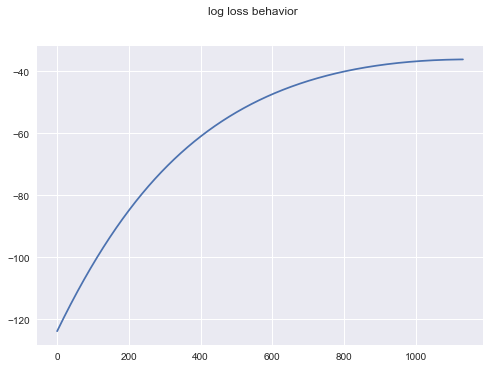

In [533]:
_=plt.plot(range(len(eL)),eL)
_=plt.suptitle('log loss behavior')

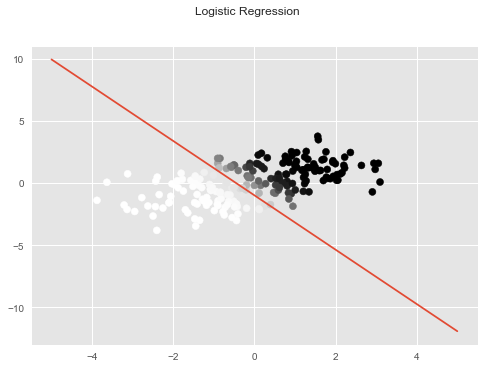

In [541]:
plt.style.use('ggplot')
P = sigma(W,D)
_=plt.scatter(x=D[0,:],y=D[1,:],c=P[0,:])
B = (W[0,:]-W[1,:])/B[1]
x = np.linspace(-5,5,100)
y = -B[0]*x-B[1]
_=plt.plot(x,y)
_=plt.suptitle("Logistic Regression")